Q1:  Implement Logistic Regression using the Pyro library referring [1] for guidance. Show both the mean prediction as well as standard deviation in the predictions over the 2d grid. Use NUTS MCMC sampling to sample the posterior. Take 1000 samples for posterior distribution and use 500 samples as burn/warm up. Use the below given dataset.
```python
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [1]:
import pyro
import pyro.distributions as dist
import torch
from pyro.infer import MCMC, NUTS 
import arviz as az
import numpy as np  

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

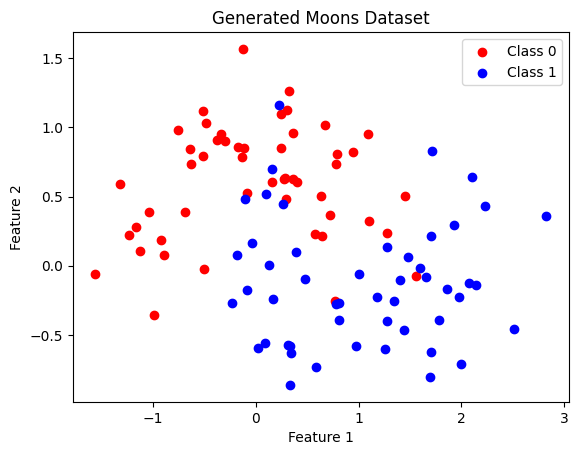

In [7]:
import matplotlib.pyplot as plt

# Separate data points by class
class_0 = X[y == 0]
class_1 = X[y == 1]

# Create a scatter plot
plt.scatter(class_0[:, 0], class_0[:, 1], label="Class 0",color='red')
plt.scatter(class_1[:, 0], class_1[:, 1], label="Class 1",color='blue')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Moons Dataset")
plt.legend()
plt.show()

In [8]:
def logistic_regression(data,labels):
    num_samples,num_features = data.shape
    # define the model
    w = pyro.sample("w", dist.Normal(torch.zeros(num_features), torch.ones(num_features)))
    b = pyro.sample("b", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    # define the model function
    with pyro.plate("data", num_samples):
        logits=torch.matmul(data,w)+b
        probs = torch.sigmoid(logits)
        # define the likelihood
        pyro.sample("obs", dist.Bernoulli(probs), obs=labels)
        

In [9]:
nuts_kernel = NUTS(logistic_regression, adapt_step_size=True)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500)

mcmc.run(X_train, y_train)

posterior_samples = mcmc.get_samples()



Sample: 100%|██████████| 1500/1500 [00:14, 103.61it/s, step size=6.30e-01, acc. prob=0.929]


/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


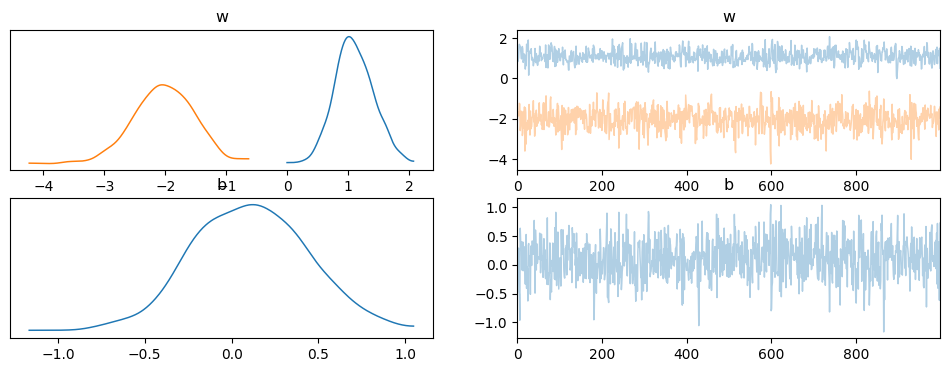

In [10]:
#create an inferencedata object
idata = az.from_pyro(mcmc)
az.plot_trace(idata, var_names=["w", "b"], compact=True);

In [ ]:
def plot_prediction_grid(X,y,posterior_samples):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100))

    # flatten grid to a list of (x, y) points
    grid=torch.cat([xx.reshape(-1,1),yy.reshape(-1,1)],dim=1)
    


In [60]:
def plot_prediction_grid(X_train, y_train, posterior_samples):
    x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100))
    grid = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)
    
    w = posterior_samples["w"].mean(dim=0)
    b = posterior_samples["b"].mean(dim=0)
    logits = torch.matmul(grid, w) + b
    pred_probs = torch.sigmoid(logits).reshape(xx.shape)

    contour = plt.contourf(xx, yy, pred_probs, 25, cmap="RdBu", vmin=0, vmax=1)
    plt.colorbar(contour)

    # Plot training data
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="RdBu", edgecolor="white", linewidth=1)

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Posterior predictive distribution")
    plt.show()


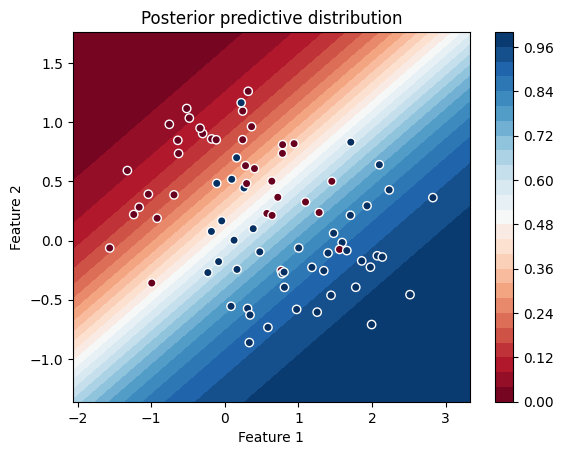

In [61]:
plot_prediction_grid(X_train,y_train,posterior_samples)